Making this even more modular so we can plot the same things atop eachother....

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.cosmology as cosmo
import pylab as pyl
import time
import pandas as pd
import matplotlib.ticker as ticker
import sys
sys.path.insert(0, '/Users/arielamaral/RM/')
from RMtools_1D.cl_RMsynth_1d import run_rmsynth

In [2]:
pwd = '/Users/arielamaral/Documents/Thesis/POSSUM/POSSUM_sims/'

#POSSUM high band

#possum_band_min = 1152. #MHz

#possum_band_max = 1440. #MHz

#EMU BAND

possum_band_min = 800 #MHz

possum_band_max = 1088 #MHz

sampling_rate = 1. #MHz

possum_freq = np.arange(possum_band_min,possum_band_max,sampling_rate) #MHz spacing between each channel

possum_freq_units = possum_freq*u.MHz
possum_lambda = possum_freq_units.to(u.meter, equivalencies=u.spectral())

We use the following Burn law (first defined in Burn 1966) to define the fractional polarization (depolarization) of our simulated sources):

$$ p(\lambda) = p_0 \exp{\left(\psi_0 + \lambda^2 RM_0\right)} \exp{\left(- \sigma_{RM}^2 \lambda^4\right)} + \mathrm{Noise} $$

In [3]:
def burn_law(p_0,sigma_rm,lamda,psi_0,RM_0,noise_lvl):#,flux):
    psi_0 = psi_0.value
    noise_array = np.random.normal(0., noise_lvl, len(lamda)) +np.random.normal(noise_lvl, noise_lvl, len(lamda))*1j
    #frac_noise_array = noise_array/flux
    p = p_0*np.exp(-1* sigma_rm**2. * lamda**4.)*np.exp(2j*(psi_0 + lamda**2. * RM_0)) + noise_array#frac_noise_array
    return p,noise_array

In [4]:
def intensity_SI(freq_array,flux,SI):
    f_0 = np.mean((freq_array[0],freq_array[-1]))
    I_f = flux * ((freq_array/(f_0))**(SI))
    return I_f

In [5]:
def double_peak(p1,p2,lamda,psi1,psi2,delta_RM,noise_lvl,flux):
    RM1 = 45.
    RM2 = RM1-delta_RM
    e
    frac_noise_array = noise_array/flux
    Ptot = p1*np.exp(2j*(psi1 + lamda**2. * RM1)) + p2*np.exp(2j*(psi2 + lamda**2. * RM2)) + frac_noise_array
    return Ptot,frac_noise_array

In [6]:
def pol_frac_noise(I,Q,U,dI,dQ,dU):
    #making sure everything is in common units:
    I = I.to(u.mJy)
    U = U.to(u.mJy)
    Q = Q.to(u.mJy)
    
    dI = dI.to(u.mJy)
    dQ = dQ.to(u.mJy)
    dU = dU.to(u.mJy)
    
    noise = np.sqrt((1/I**2.)*(dQ**2. +dU**2.) + ((-(Q+U)/I**2)*dI)**2.)
    return noise

In [10]:
def get_sigma_add(num_sources,p_0,sigma_rm,possum_lambda,psi_0,RM_0,noise_lvl,possum_freq):

    sigmaAddU = np.zeros(num_sources)

    sigmaAddQ = np.zeros(num_sources)

    dSigmaAddMinusQ = np.zeros(num_sources)

    dSigmaAddPlusQ = np.zeros(num_sources)

    dSigmaAddMinusU = np.zeros(num_sources)

    dSigmaAddPlusU = np.zeros(num_sources)

    snrPIchan = np.zeros(num_sources)


    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(figsize=(14,14))
    plt.suptitle(r"Individual Spectra Examples",fontsize=28)
    for i in np.arange(0,num_sources):
        p,noise_array = burn_law(p_0,sigma_rm[i],possum_lambda.value,psi_0,RM_0,noise_lvl[i])

        possum_freq_Hz = possum_freq*1000000.
        q = np.real(p)
        u = np.imag(p)
        if noise_lvl[i] == 0.:
            print('Zero noise!')
            dq = np.zeros(len(np.real(p))) +1.
            du = np.zeros(len(np.real(p))) +1.
        elif noise_lvl[i] != 0.:
            dq = np.real(noise_array)
            du = np.imag(noise_array)

        data = np.c_[possum_freq_Hz,q,u,dq,du].T

        RM_output = run_rmsynth(data,verbose=False)


        sigmaAddU[i] = RM_output[0]['sigmaAddU']

        sigmaAddQ[i] = RM_output[0]['sigmaAddQ']


        dSigmaAddMinusQ[i] = RM_output[0]['dSigmaAddMinusQ']
        dSigmaAddPlusQ[i]= RM_output[0]['dSigmaAddPlusQ']

        dSigmaAddMinusU[i] = RM_output[0]['dSigmaAddMinusU']
        dSigmaAddPlusU[i] = RM_output[0]['dSigmaAddPlusU']

        #ADD THE SNR AS AN OUTPUT HERE
        snrPIchan[i] = RM_output[0]['snrPIchan']
        
        if i%250 == 0:#i==0 or i==249 or i==499 or i==749 or i==999:#i%250 == 0:
            #LETS PLOT FOUR OF THESE GUYS
            RM_output2 = run_rmsynth(data,phiMax_radm2=300, dPhi_radm2=2,verbose=False)
            phi = RM_output2[1]['phiArr_radm2']
            dirtyFDF = RM_output2[1]['dirtyFDF']
            plot_index = int((i/250)+1)
            print("Plot index is: ", plot_index)
            plt.subplot(2,2,plot_index)
            plt.plot(phi,np.absolute(dirtyFDF),linewidth=2,label = r'$\sigma_{RM}$ ='+str(sigma_rm[i]))
            plt.xlabel(r"Faraday Depth $[rad/m^2]$",fontsize=20)
            plt.ylabel(r"\%p",fontsize=15)
            plt.xlim((min(phi),max(phi)))
            plt.grid()
            plt.tick_params(labelsize=25)
            plt.legend(fontsize=14)
    plt.show()
            

    #Defining Sigma Add Total:
    sigmaAdd = sigmaAddQ + sigmaAddU
    
    return sigmaAdd, snrPIchan

# Simple Sources with non-varying noise (high p/Stokes I case)

In [11]:
num_sources = 1001 #1000

##########################################
#PARAMETERS THAT CAN BE CHANGED

#the following values are taken from: http://askap.org/possum/validation/pol_data_SB10168.html
#This is to get realistic values

#these values are from the histograms


#I = np.arange(0.0001,0.2,num_sources)*u.Jy #the max value is 0.2 Jy
#Q = np.arange(0.0001,0.0075,num_sources)*u.Jy #the max value is 0.0075 Jy
#U = np.arange(0.0001,0.0075,num_sources)*u.Jy #the max value is 0.0075 Jy

p_0 = 0.25 #30% polarized - going to keep this the same for all sources

I = 0.2*u.Jy
Q = (I*p_0)/2. #keeping U and Q the same
U = (I*p_0)/2.


#values are from "Beam Noise (image)"
dI =0.5 *u.mJy
dQ =0.35 *u.mJy
dU = 0.35 *u.mJy

pol_noise = pol_frac_noise(I,Q,U,dI,dQ,dU)

print("The fractional polarized noise is: ", str(pol_noise))

psi_0 = 0.5*np.arctan(U/Q) #I had this set to zero before

RM_0 = 30. #Rotation measure, rad/m^2

noise_lvl = np.zeros(num_sources)+pol_noise#+0.001
    

#changing parameters
delta_funcs =np.zeros(20)
non_zero = int(num_sources - len(delta_funcs))
sigma_rm = np.concatenate((delta_funcs,np.linspace(0,145,non_zero))) #this is the spread in the RM


The fractional polarized noise is:  0.002552572232082767


Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Plot index is:  1
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I dat

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

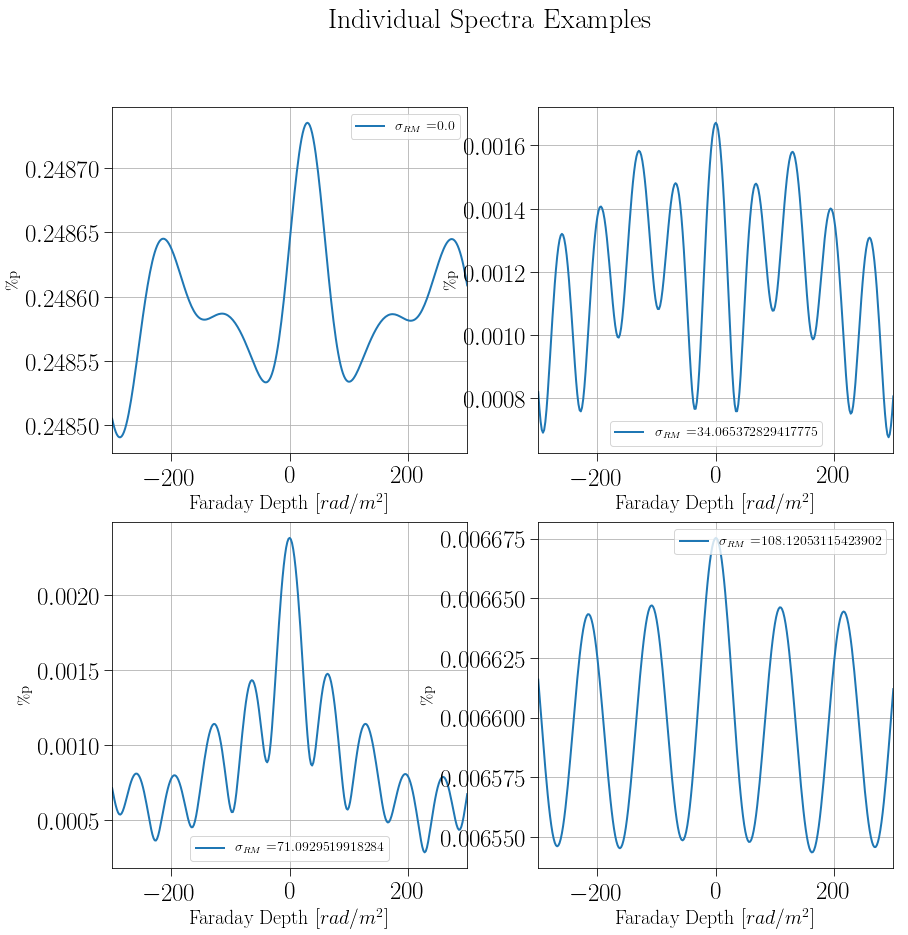

In [12]:
sigmaAdd, snrPIchan =get_sigma_add(num_sources,p_0,sigma_rm,possum_lambda,psi_0,RM_0,noise_lvl,possum_freq)

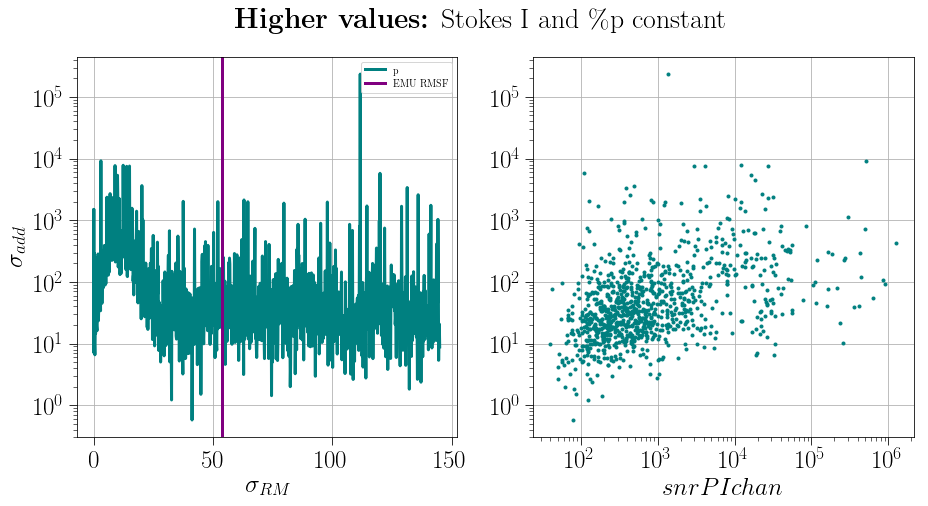

In [13]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(15,7))
plt.suptitle(r"\textbf{Higher values:} Stokes I and \%p constant",fontsize=28)

plt.subplot(121)
#plt.title(r"Input $\sigma_{RM}$ (width of RM) vs. output $\sigma_{add}$, noise and \%p constant",fontsize=28)
plt.plot(sigma_rm,sigmaAdd,linewidth=3,color='teal',label='p')
plt.xlabel(r"$\sigma_{RM}$",fontsize=25)
plt.ylabel(r"$\sigma_{add}$",fontsize=25)
plt.axvline(x=53.82,linewidth=3,color='purple',label='EMU RMSF')
plt.grid()
plt.yscale('log')
plt.tick_params(labelsize=25)
plt.legend()

plt.subplot(122)
#plt.show()
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.figure(figsize=(10,7))
#plt.title(r"output snrPIchan vs. output $\sigma_{RM}$, noise and \%p constant",fontsize=28)
plt.plot(snrPIchan,sigmaAdd,'.',linewidth=3,color='teal',label='p')
plt.xlabel(r"$snrPIchan$",fontsize=25)
#plt.ylabel(r"$\sigma_{add}$",fontsize=25)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.tick_params(labelsize=25)
plt.show()

# Simple Sources with "average" %p values, and "average" Stokes I values

This is an example of a more "normal" case than the one above, which had the maximum Stokes I and fractional polarization detected by POSSUM.

In [14]:
p_0_med = 0.1 

I_med = 0.075*u.Jy
Q_med = (I_med*p_0)/2. #keeping U and Q the same
U_med = (I_med*p_0)/2.

pol_noise_med = pol_frac_noise(I_med,Q_med,U_med,dI,dQ,dU)

print("The fractional polarized noise is: ", str(pol_noise_med))

psi_0_med = 0.5*np.arctan(U_med/Q_med) #I had this set to zero before

RM_0 = 50. #Rotation measure, rad/m^2

noise_lvl_med = np.zeros(num_sources)+pol_noise_med#+0.001

The fractional polarized noise is:  0.006806859285554046


Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Plot index is:  1
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I dat

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

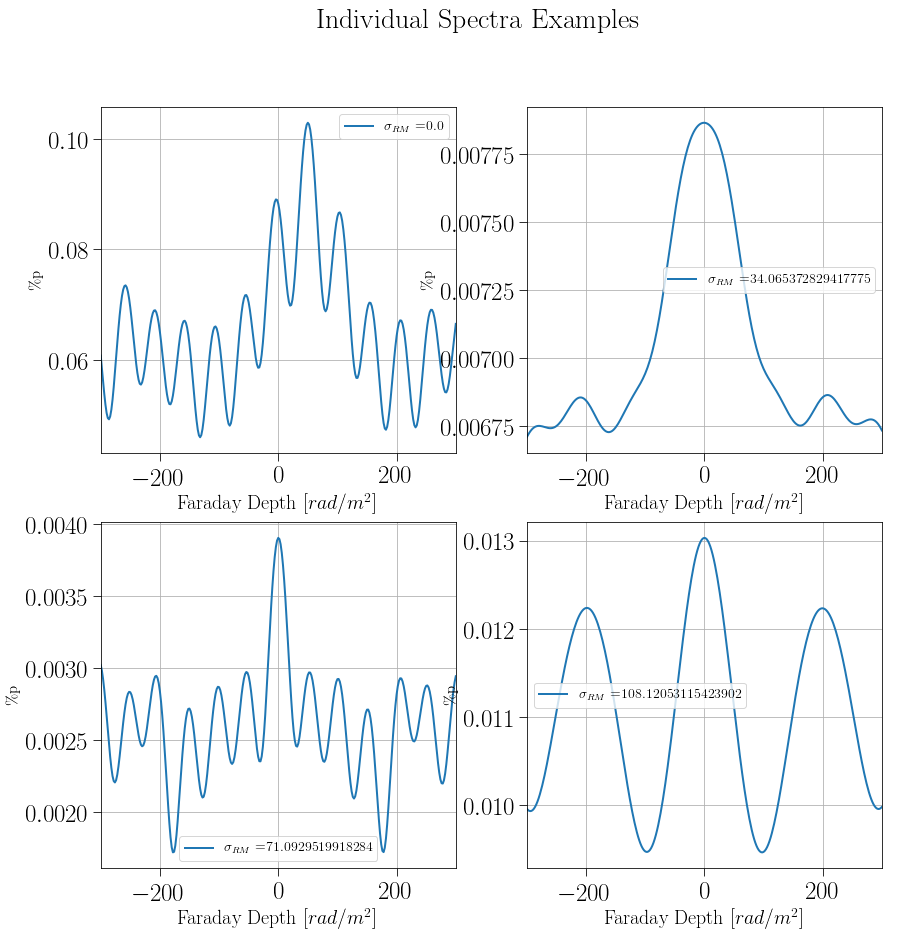

In [15]:
sigmaAdd_med, snrPIchan_med = get_sigma_add(num_sources,p_0_med,sigma_rm,possum_lambda,psi_0_med,RM_0,noise_lvl_med,possum_freq)

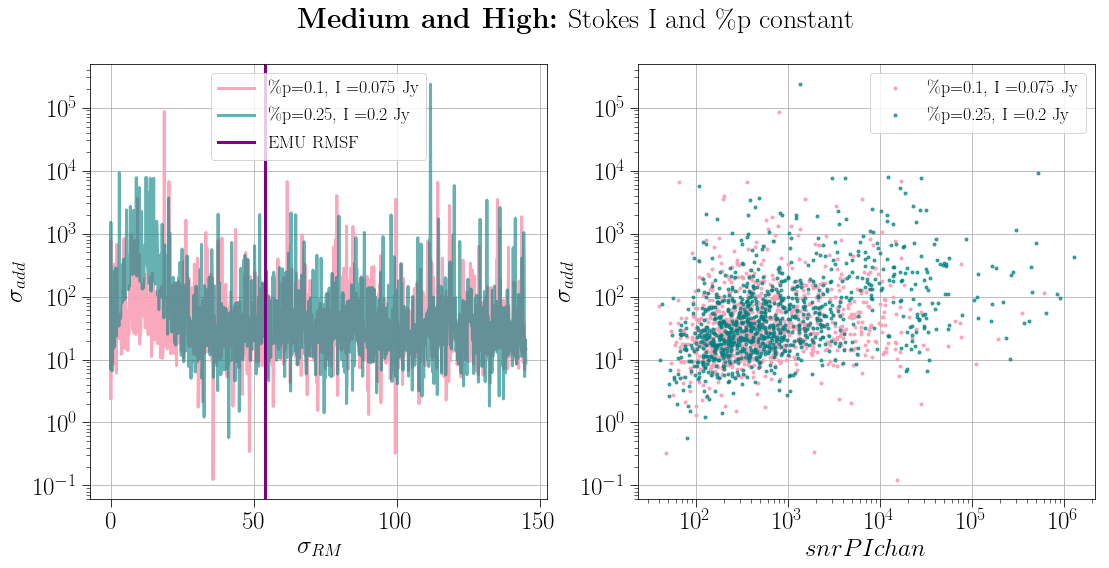

In [16]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(18,8))
plt.suptitle(r"\textbf{Medium and High:} Stokes I and \%p constant",fontsize=28)

plt.subplot(121)
plt.plot(sigma_rm,sigmaAdd_med,linewidth=3,color='#fa9fb5',label=r'\%p='+str(p_0_med)+', I ='+str(I_med),alpha=0.9)
plt.plot(sigma_rm,sigmaAdd,linewidth=3,color='teal',label=r'\%p='+str(p_0)+', I ='+str(I),alpha=0.6)


plt.xlabel(r"$\sigma_{RM}$",fontsize=25)
plt.ylabel(r"$\sigma_{add}$",fontsize=25)
plt.axvline(x=53.82,linewidth=3,color='purple',label='EMU RMSF')
plt.grid()
plt.yscale('log')
plt.tick_params(labelsize=25)
plt.legend(fontsize=18)

plt.subplot(122)
plt.plot(snrPIchan_med,sigmaAdd_med,'.',color='#fa9fb5',label=r'\%p='+str(p_0_med)+', I ='+str(I_med),alpha=0.9)
plt.plot(snrPIchan,sigmaAdd,'.',color='teal',label=r'\%p='+str(p_0)+', I ='+str(I),alpha=0.7)
plt.xlabel(r"$snrPIchan$",fontsize=25)
plt.ylabel(r"$\sigma_{add}$",fontsize=25)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=18)
plt.grid()
plt.tick_params(labelsize=25)
plt.show()

# Simple Sources with "low" %p values, and "alow" Stokes I values

This is an example of a lower SNR case than the others above.

In [17]:
p_0_low = 0.05 

I_low = 0.025*u.Jy
Q_low = (I_low*p_0)/2. #keeping U and Q the same
U_low = (I_low*p_0)/2.

pol_noise_low = pol_frac_noise(I_low,Q_low,U_low,dI,dQ,dU)

print("The fractional polarized noise is: ", str(pol_noise_low))

psi_0_low = 0.5*np.arctan(U_low/Q_low) #I had this set to zero before

RM_0 = 50. #Rotation measure, rad/m^2

noise_lvl_low = np.zeros(num_sources)+pol_noise_low#+0.001

The fractional polarized noise is:  0.020420577856662136


Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Plot index is:  1
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I dat

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

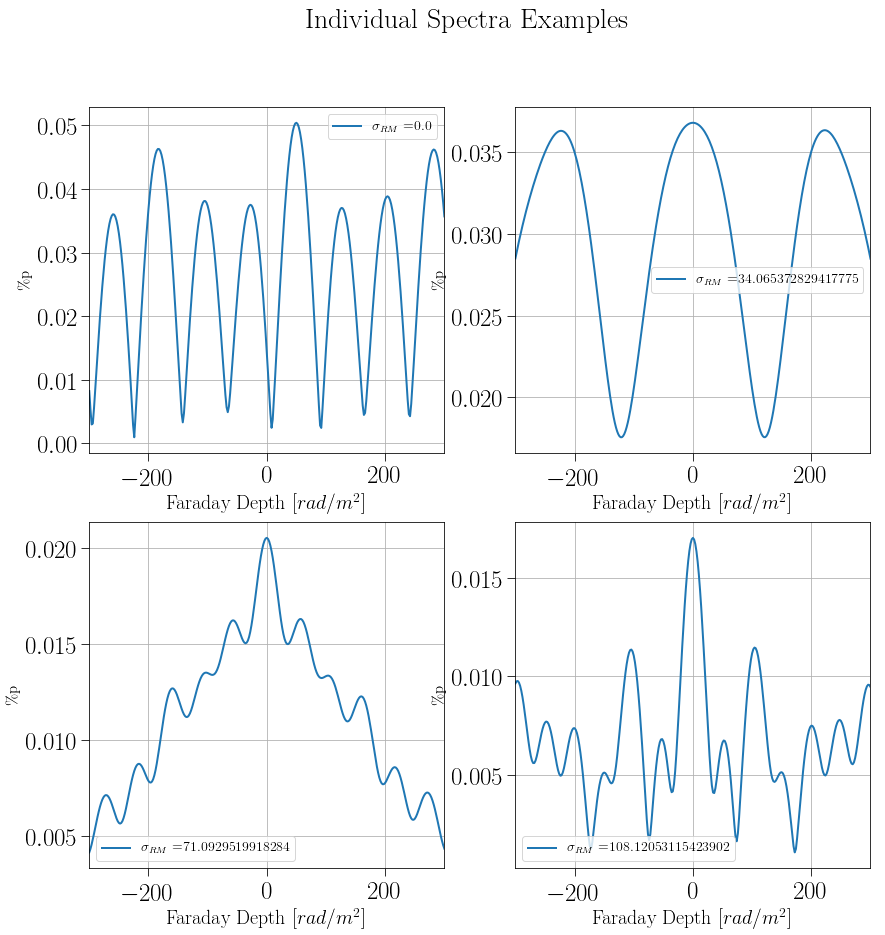

In [18]:
sigmaAdd_low, snrPIchan_low = get_sigma_add(num_sources,p_0_low,sigma_rm,possum_lambda,psi_0_low,RM_0,noise_lvl_low,possum_freq)

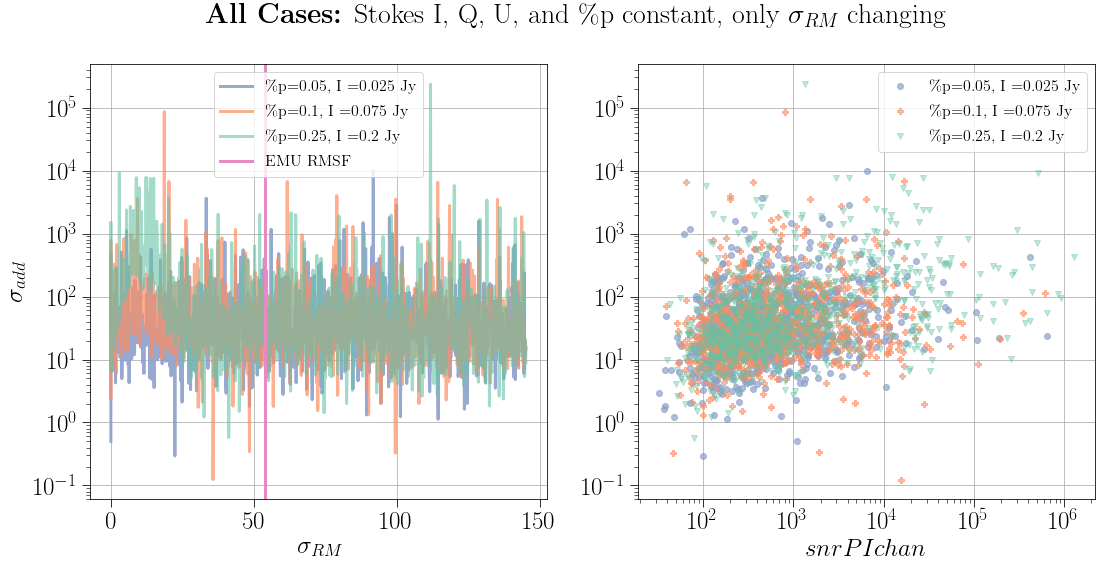

In [19]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(18,8))
plt.suptitle(r"\textbf{All Cases:} Stokes I, Q, U, and \%p constant, only $\sigma_{RM}$ changing",fontsize=28)
plt.subplot(121)
plt.plot(sigma_rm,sigmaAdd_low,linewidth=3,color='#8da0cb',label=r'\%p='+str(p_0_low)+', I ='+str(I_low),alpha=0.9)
plt.plot(sigma_rm,sigmaAdd_med,linewidth=3,color='#fc8d62',label=r'\%p='+str(p_0_med)+', I ='+str(I_med),alpha=0.7)
plt.plot(sigma_rm,sigmaAdd,linewidth=3,color='#66c2a5',label=r'\%p='+str(p_0)+', I ='+str(I),alpha=0.6)

plt.xlabel(r"$\sigma_{RM}$",fontsize=25)
plt.ylabel(r"$\sigma_{add}$",fontsize=25)
plt.axvline(x=53.82,linewidth=3,color='#e78ac3',label='EMU RMSF')
plt.grid()
plt.yscale('log')
plt.tick_params(labelsize=25)
plt.legend(fontsize=16)
#plt.show()

#plt.title(r"output snrPIchan vs. output $\sigma_{RM}$, noise and \%p constant",fontsize=28)
plt.subplot(122)
plt.plot(snrPIchan_low,sigmaAdd_low,'o',color='#8da0cb',label=r'\%p='+str(p_0_low)+', I ='+str(I_low),alpha=0.7)
plt.plot(snrPIchan_med,sigmaAdd_med,'P',color='#fc8d62',label=r'\%p='+str(p_0_med)+', I ='+str(I_med),alpha=0.6)
plt.plot(snrPIchan,sigmaAdd,"v",color='#66c2a5',label=r'\%p='+str(p_0)+', I ='+str(I),alpha=0.4)

plt.xlabel(r"$snrPIchan$",fontsize=25)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.grid()
plt.tick_params(labelsize=25)
plt.show()

# Zero Tests, to make sure SNR comes back as very low.... this is a sanity check!

In [20]:
p_0_zero = 0.00000001 

I_zero = 0.0000000001*u.Jy
Q_zero = (I_low*p_0)/2. #keeping U and Q the same
U_zero = (I_low*p_0)/2.

pol_noise_zero = pol_frac_noise(I_zero,Q_zero,U_zero,dI,dQ,dU)

print("The fractional polarized noise is: ", str(pol_noise_zero))

psi_0_zero = 0.5*np.arctan(U_zero/Q_zero) #I had this set to zero before

RM_0 = 50. #Rotation measure, rad/m^2

noise_lvl_zero = np.zeros(num_sources)+pol_noise_zero#+0.001

The fractional polarized noise is:  312499999999999.94


Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Plot index is:  1
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I dat

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no Stokes I data in use.
Warn: no

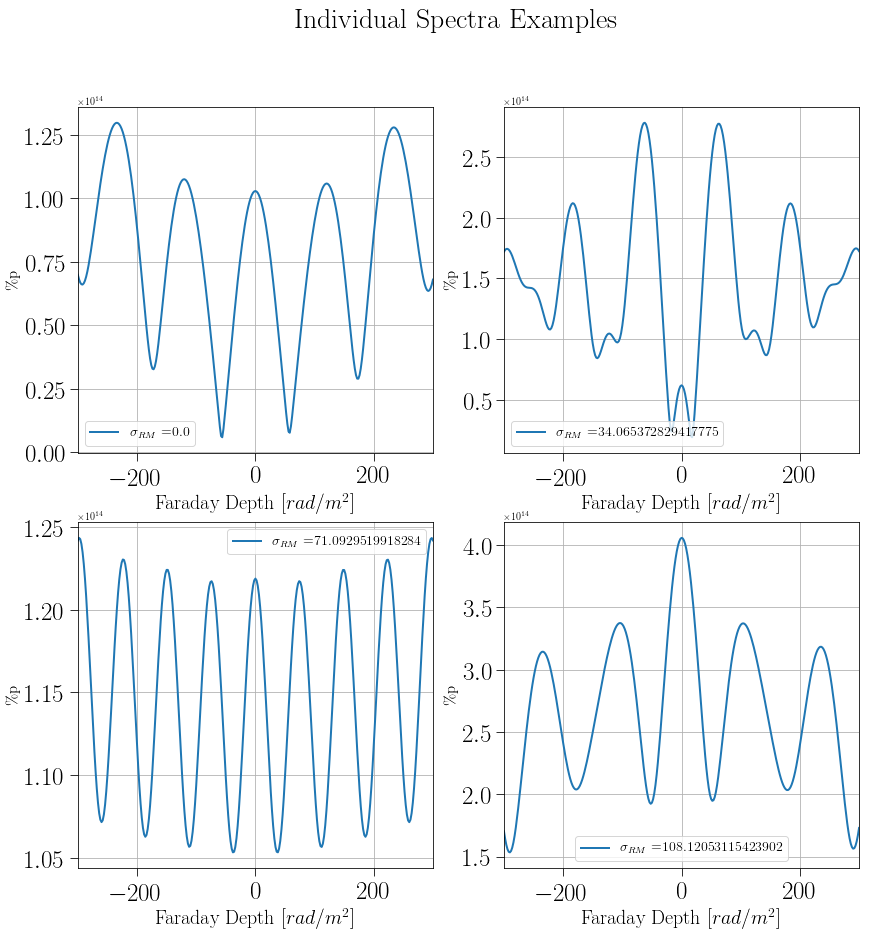

In [21]:
sigmaAdd_zero, snrPIchan_zero = get_sigma_add(num_sources,p_0_zero,sigma_rm,possum_lambda,psi_0_zero,RM_0,noise_lvl_zero,possum_freq)

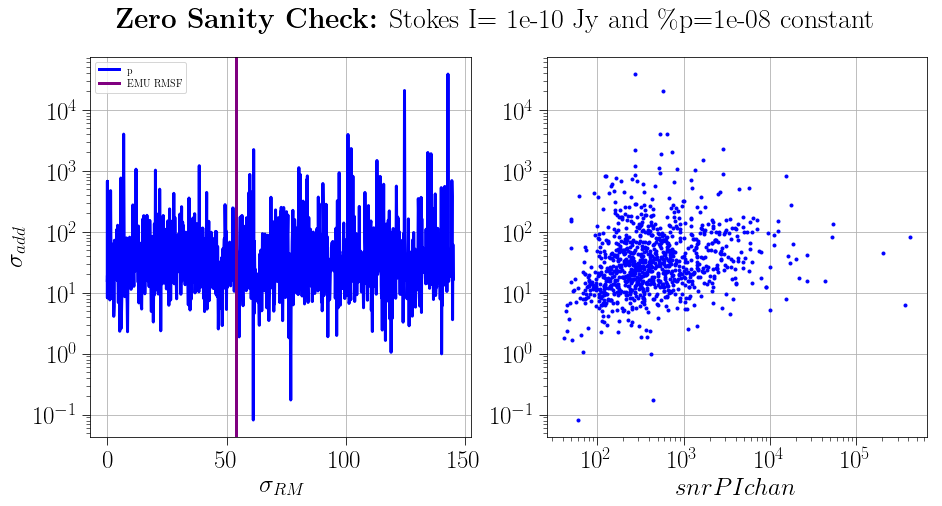

In [26]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(15,7))
plt.suptitle(r"\textbf{Zero Sanity Check:} Stokes I= " + str(I_zero) + " and \%p=" + str(p_0_zero)+" constant",fontsize=28)

plt.subplot(121)
plt.plot(sigma_rm,sigmaAdd_zero,linewidth=3,color='blue',label='p')
plt.xlabel(r"$\sigma_{RM}$",fontsize=25)
plt.ylabel(r"$\sigma_{add}$",fontsize=25)
plt.axvline(x=53.82,linewidth=3,color='purple',label='EMU RMSF')
plt.grid()
plt.yscale('log')
plt.tick_params(labelsize=25)
plt.legend()

plt.subplot(122)
plt.plot(snrPIchan_zero,sigmaAdd_zero,'.',linewidth=3,color='blue',label='p')
plt.xlabel(r"$snrPIchan$",fontsize=25)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.tick_params(labelsize=25)
plt.show()


# Checking my own SNR vs. snrPIchan

Here I'm checking what my own derived polarized signal to noise is versus the snrPIchan

In [23]:
SNR_polfrac = p_0/pol_noise
SNR_pol = (Q+U)/(dQ.to(u.Jy)+dU.to(u.Jy))

print(SNR_polfrac)
print(SNR_pol)

97.94042137487835
71.42857142857143


In [24]:
SNR_polfrac_med = p_0_med/pol_noise_med
SNR_pol_med = (Q_med+U_med)/(dQ.to(u.Jy)+dU.to(u.Jy))

print(SNR_polfrac_med)
print(SNR_pol_med)

14.691063206231753
26.785714285714285


In [25]:
SNR_polfrac_low = p_0_low/pol_noise_low
SNR_pol_low = (Q_low+U_low)/(dQ.to(u.Jy)+dU.to(u.Jy))

print(SNR_polfrac_low)
print(SNR_pol_low)

2.4485105343719593
8.928571428571429
